In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymoo
from pymoo.core.problem import Problem
t = 0
class MyProblem(Problem):

    PV = np.array([10, 9.8, 6, 4.5, 7.8, 2.8, 0]) #PV inverter output power, kW
    Load = np.array([100, 108, 150, 150, 10, 11, 11]) #Load, kW

    balance_eps = 0.01 #equality constraint relaxing coefficient

    DGU1_pmin = 0.3 #DGU1 min power
    DGU2_pmin = 0.3 #DGU2 min power
    P_dgu1 = 75 #DGU1 rated power, kW
    P_dgu2 = 75 #DGU1 rated power, kW

    P_PV_inv = 25 #PV inverter rated power, kW

    P_ESS_inv = 50 #ESS bidirectional inverter absolute rated discharge/charge power, kW

    ESS_c = 1000 #ESS capacity, kWh
        
    SOC_prev = 30 #ESS state of charge at t = 0
    SOC_min = 30
    SOC_max = 100

    def __init__(self):
        super().__init__(n_var=5*7,
                         n_obj=1,
                         n_constr=3,
                         xl=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, self.DGU1_pmin*self.P_dgu1, 
                         self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2, self.DGU2_pmin*self.P_dgu2,
                         -self.P_ESS_inv, -self.P_ESS_inv, -self.P_ESS_inv, -self.P_ESS_inv, -self.P_ESS_inv, -self.P_ESS_inv, -self.P_ESS_inv]),
                         xu=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, self.P_dgu1, self.P_dgu1, self.P_dgu1, self.P_dgu1, self.P_dgu1, self.P_dgu1, self.P_dgu1,
                         self.P_dgu2, self.P_dgu2, self.P_dgu2, self.P_dgu2, self.P_dgu2, self.P_dgu2, self.P_dgu2,
                         self.P_ESS_inv, self.P_ESS_inv, self.P_ESS_inv, self.P_ESS_inv, self.P_ESS_inv, self.P_ESS_inv, self.P_ESS_inv]))

    def _evaluate(self, X, out, *args, **kwargs):

        f =  X[:,0]*X[:,14]*200 + X[:,1]*X[:,15]*200 + X[:,2]*X[:,16]*200 + X[:,3]*X[:,17]*200 + X[:,4]*X[:,18]*200 + X[:,5]*X[:,19]*200 + X[:,6]*X[:,20]*200 
        + X[:,7]*X[:,21]*200 + X[:,8]*X[:,22]*200 + X[:,9]*X[:,23]*200 + X[:,10]*X[:,24]*200 + X[:,11]*X[:,25]*200 + X[:,12]*X[:,26]*200 + X[:,13]*X[:,27]*200
        + X[:,28]*0.002 + X[:,29]*0.002 + X[:,30]*0.002 + X[:,31]*0.002 + X[:,32]*0.002 + X[:,33]*0.002 + X[:,34]*0.002 #objective function 

        g1 = (self.Load - X[:,[0,1,2,3,4,5,6]]*X[:,[14,15,16,17,18,19,20]] - X[:,[7,8,9,10,11,12,13]]*X[:,[21,22,23,24,25,26,27]] -
        X[:,[28,29,30,31,32,33,34]] - self.PV)**2 - self.balance_eps #active power balance constraint
        #print('***')
        socs=np.empty([50,7])
        SOC_t = 35
        # for i in range(28, 35):
        #     if i==28:
        #         socs.append((100*X[:,i]/self.ESS_c - SOC_t) + 30)
        #         SOC_t = (100*X[:,i]/self.ESS_c - SOC_t)
        #     else:
        #         socs.append((100*X[:,i]/self.ESS_c - SOC_t) + 30)
        #         SOC_t = (100*X[:,i]/self.ESS_c - SOC_t)

        deltas = 100*X[:, 28:35]/self.ESS_c

        

        dgu1_minimum_uptime = 2
        dgu2_minimum_uptime = 2
        dgu1_minimum_downtime = 2
        dgu2_minimum_downtime = 2

        dgu1_uptime = 0
        dgu2_uptime = 2
        dgu1_downtime = 2
        dgu2_downtime = 0

        if dgu1_uptime <= 0:
            dgu1_start = 0
        else:
            dgu1_start = 1

        if dgu2_uptime <= 0:
            dgu2_start = 0
        else:
            dgu2_start = 1

        dgu1_uptimes=np.empty([50,7])
        dgu2_uptimes=np.empty([50,7])

        for i in range (0, len(deltas)):
            for j in range(0,7):
                if j==0:
                    SOC = SOC_t - deltas[i][0]
                    socs[i][0] = SOC
                    #socs.append(SOC)

                    dgu1_uptimes[i][0] = (dgu1_uptime - dgu1_minimum_uptime)(dgu1_start-X[i][0])
                else:
                    SOC = SOC - deltas[i][j]
                    socs[i][j] = SOC
                    #socs.append(SOC)

                    dgu1_uptimes[i][j] = ([X[i][j]+= for k in range(0, j+1) - dgu1_minimum_uptime)(dgu1_start-X[i][0])


        #print(np.array(socs))
        #print('ara', np.array(socs))


        # g2 = (100*X[:,28]/self.ESS_c - SOC_t) + (100*X[:,29]/self.ESS_c - (100*X[:,28]/self.ESS_c - 100*X[:,29]/self.ESS_c))
        # + (100*X[:,30]/self.ESS_c - (100*X[:,29]/self.ESS_c - 100*X[:,30]/self.ESS_c)) + (100*X[:,31]/self.ESS_c - (100*X[:,30]/self.ESS_c - 100*X[:,31]/self.ESS_c))
        # + (100*X[:,32]/self.ESS_c - (100*X[:,31]/self.ESS_c - 100*X[:,32]/self.ESS_c)) + (100*X[:,33]/self.ESS_c - (100*X[:,32]/self.ESS_c - 100*X[:,33]/self.ESS_c))
        # + (100*X[:,34]/self.ESS_c - (100*X[:,33]/self.ESS_c - 100*X[:,34]/self.ESS_c)) #min SOC constraint

        g2 = 30 - socs

        g3 = socs - 100

        #print(socs)

        #print(g2)

        #print('karo', g2)
        #print(g2.shape)
        #print(X.T[4])

        #g3 = -100*X[4]/self.ESS_c - 100 + SOC_t  #max SOC constraint SOC_prev - 100*x[6]/ESS_c - 100,

        out["F"] = np.column_stack([f])
        out["G"] = np.column_stack([g1, g2, g3])


vectorized_problem = MyProblem()

In [92]:
# if the first variable is an integer and the second a real value
# mask = (['real']*300*4 + ['int']*300*4)
mask = ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", 
"real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real"]
# e.g. if first two are integers and third real it would be
# mask = ["int", "int", real"]
# for the purpose of plotting we limit us to two variables here
import numpy as np
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.optimize import minimize
from pymoo.interface import sample

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx"),
    "int": get_crossover("int_sbx")
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm"),
    "int": get_mutation("int_pm")
})

#XOR = sample(sampling, 7, 5)

algorithm = NSGA2(
    pop_size=50,
    sampling=sampling, crossover=crossover, mutation=mutation,
    eliminate_duplicates=True, 
)

# algorithm = PSO(max_velocity_rate=0.025, sampling = sampling)

# res = minimize(vectorized_problem,
#                algorithm,
#                seed=1,
#                save_history=True,
#                verbose=True)

termination = get_termination("n_gen", 5000)



res = minimize(vectorized_problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print(res.X)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      50 |  1.13703E+04 |  4.55339E+04 |       1 |            - |            -
    2 |     100 |  7.15900E+03 |  2.59177E+04 |       1 |  7.26902E+03 |        ideal
    3 |     150 |  3.80210E+03 |  1.77211E+04 |       1 |  3.29807E+03 |        ideal
    4 |     200 |  3.28308E+03 |  1.20735E+04 |       1 |  8.85349E+03 |        ideal
    5 |     250 |  2.13762E+03 |  7.89947E+03 |       1 |  4.01255E+03 |        ideal
    6 |     300 |  2.10542E+03 |  5.34266E+03 |       1 |  6.27721E+02 |        ideal
    7 |     350 |  2.10542E+03 |  3.90422E+03 |       1 |  0.00000E+00 |            f
    8 |     400 |  2.10542E+03 |  3.23574E+03 |       1 |  0.00000E+00 |            f
    9 |     450 |  9.98034E+02 |  2.62001E+03 |       1 |  1.78719E+04 |        ideal
   10 |     500 |  8.80280E+02 |  2.18511E+03 |       1 |  4.11462E+03 |        ideal
   11 |     550 |  8.80280E+02 |  1.89182E+03 |       

In [93]:
res.G

array([-6.41497703e-04, -8.84305295e-03, -9.74768438e-04, -6.16949178e-03,
       -5.26907506e-03, -4.82303674e-03, -4.02279814e-03, -4.98931944e+00,
       -2.67173103e+00, -2.98527480e+00, -2.12301836e+00, -1.90989653e+00,
       -1.09709164e+00, -4.82287804e-03, -6.50106806e+01, -6.73282690e+01,
       -6.70147252e+01, -6.78769816e+01, -6.80901035e+01, -6.89029084e+01,
       -6.99951771e+01])

In [94]:
itog = res.X.reshape(5, 7).T

In [95]:
itog[0]

array([1, 1, 42.13656312929501, 47.65989192308074, 0.10680559525557529],
      dtype=object)

In [96]:
PV = np.array([10, 9.8, 6, 4.5, 7.8, 2.8, 0]) #PV inverter output power, kW
Load = np.array([100, 108, 150, 150, 10, 11, 11]) #Load, kW

#for i in range(0,7):
    #print(itog[i][0]*itog[i][2]+itog[i][1]*itog[i][3]+itog[i][4]+PV[i])

#print(Load)
socco=[]
SOC = 35
for i in range(0,7):
    #print(itog[i])
    if i==0:
        SOC = SOC - 100*itog[i][4]/1000
        #print(SOC)
        socco.append(SOC)
    else:
        #print('was', SOC)
        SOC = SOC - 100*itog[i][4]/1000
        #print(SOC)
        socco.append(SOC)

In [97]:
itog.T[0]

array([1, 0, 1, 1, 0, 0, 0], dtype=object)

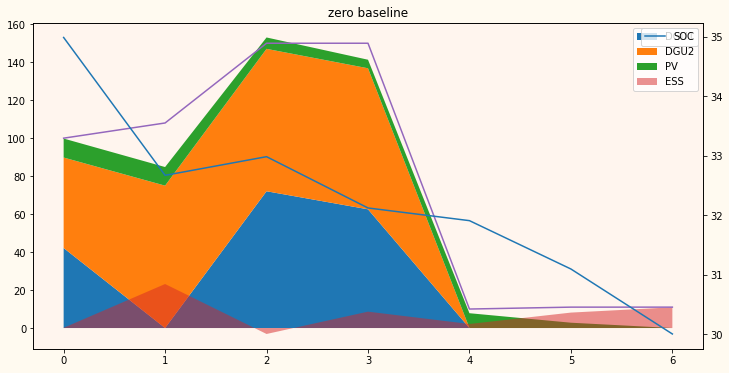

In [98]:
itoggo = pd.DataFrame()
itoggo['Load'] = Load
itoggo['DGU1'] = itog.T[0]*itog.T[2]
itoggo['DGU2'] = itog.T[1]*itog.T[3]
itoggo['PV'] = PV
itoggo['ESS'] = itog.T[4]
itoggo['SOC'] = socco

labels = ['DGU1', 'DGU2', 'PV']
fig, ax = plt.subplots()

ax.stackplot(itoggo.index, itoggo['DGU1'].astype(float), itoggo['DGU2'].astype(float),
itoggo['PV'].astype(float), labels=labels, baseline = 'zero')

ax.stackplot(itoggo.index, itoggo['ESS'].astype(float), labels=['ESS'], baseline = 'zero', alpha=0.5)
ax.plot(itoggo['Load'])
ax.set_title('zero baseline')
ax2=ax.twinx()
ax2.plot(itoggo['SOC'], label='SOC')
fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
ax.legend()
ax2.legend()
plt.show()

In [40]:
PV = np.array([10, 9.8, 6, 4.5, 7.8, 2.8, 0]) #PV inverter output power, kW
Load = np.array([100, 108, 150, 150, 130, 165, 170]) #Load, kW

In [44]:
Load

array([100, 108, 150, 150, 130, 165, 170])

In [56]:
Load-itog.T[2]-itog.T[3]+itog.T[4]

array([61.5878986324095, 87.94753553857555, 108.53845992978195,
       120.71469132417596, -46.86812688237571, 27.006650469486463,
       32.20929134395562], dtype=object)

In [17]:
itog

array([[1, 1, 32.70895377825031, 72.538278148284, -15.34289793472284],
       [0, 1, 52.87213083585759, 62.390332844301405, 35.74001646224622],
       [1, 1, 50.48953248876884, 53.31198299863926, 40.10185289411271],
       [1, 1, 61.524198454820535, 54.99185045017019, 29.03713258781772],
       [0, 1, 35.72273422865879, 10.78662393217634, -8.676373464718898],
       [0, 0, 23.567142560637294, 31.499439989252018, 8.110045609540435],
       [0, 0, 56.27036382033094, 54.05124043277425, 11.023567534432003]],
      dtype=object)

In [78]:
PV

array([10. ,  9.8,  6. ,  4.5,  7.8,  2.8,  0. ])

In [149]:
mask = ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", 
"real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real", "real"]

In [154]:
mask[28:35]

['real', 'real', 'real', 'real', 'real', 'real', 'real']